# 1. Getting VizDoom Up and Running

In [ ]:
!pip install vizdoom

In [2]:
# !cd github & git clone https://github.com/mwydmuch/ViZDoom

In [2]:
# Import vizdoom for game env
from vizdoom import * 
# Import random for action sampling
import random
# Import time for sleeping
import time 
# Import numpy for identity matrix
import numpy as np

In [3]:
# Setup game
game = DoomGame()
game.load_config('./VizDoom/scenarios/defend_the_center.cfg')
game.init()

In [4]:
# This is the set of actions we can take in the environment
actions = np.identity(3, dtype=np.uint8)

In [5]:
state = game.get_state()

In [6]:
state.game_variables

array([ 26., 100.])

In [ ]:
# Loop through episodes 
episodes = 10 
for episode in range(episodes): 
    # Create a new episode or game 
    game.new_episode()
    # Check the game isn't done 
    while not game.is_episode_finished(): 
        # Get the game state 
        state = game.get_state()
        # Get the game image 
        img = state.screen_buffer
        # Get the game variables - ammo
        info = state.game_variables
        # Take an action
        reward = game.make_action(random.choice(actions),4)
        # Print rewward 
        print('reward:', reward) 
        time.sleep(0.02)
    print('Result:', game.get_total_reward())
    time.sleep(2)

In [7]:
game.close()

# 2. Converting it to a Gym Environment

In [ ]:
!pip install gym

In [8]:
# Import environment base class from OpenAI Gym
from gym import Env
# Import gym spaces 
from gym.spaces import Discrete, Box
# Import opencv 
import cv2

In [ ]:
game.get_state().screen_buffer.shape

In [18]:
# Create Vizdoom OpenAI Gym Environment
class VizDoomGym(Env): 
    # Function that is called when we start the env
    def __init__(self, render=False): 
        # Inherit from Env
        super().__init__()
        # Setup the game 
        self.game = DoomGame()
        self.game.load_config('./VizDoom/scenarios/defend_the_center.cfg')
        
        # Render frame logic
        if render == False: 
            self.game.set_window_visible(False)
        else:
            self.game.set_window_visible(True)
        
        # Start the game 
        self.game.init()
        
        # Create the action space and observation space
        self.observation_space = Box(low=0, high=255, shape=(100,160,1), dtype=np.uint8) 
        self.action_space = Discrete(3)
        
    # This is how we take a step in the environment
    def step(self, action):
        # Specify action and take step 
        actions = np.identity(3)
        reward = self.game.make_action(actions[action], 4) 
        
        # Get all the other stuff we need to retun 
        if self.game.get_state(): 
            state = self.game.get_state().screen_buffer
            state = self.grayscale(state)
            ammo = self.game.get_state().game_variables[0]
            info = ammo
        else: 
            state = np.zeros(self.observation_space.shape)
            info = 0 
        
        info = {"info":info}
        done = self.game.is_episode_finished()
        
        return state, reward, done, info 
    
    # Define how to render the game or environment 
    def render(): 
        pass
    
    # What happens when we start a new game 
    def reset(self): 
        self.game.new_episode()
        state = self.game.get_state().screen_buffer
        return self.grayscale(state)
    
    # Grayscale the game frame and resize it 
    def grayscale(self, observation):
        gray = cv2.cvtColor(np.moveaxis(observation, 0, -1), cv2.COLOR_BGR2GRAY)
        resize = cv2.resize(gray, (160,100), interpolation=cv2.INTER_CUBIC)
        state = np.reshape(resize, (100,160,1))
        return state
    
    # Call to close down the game
    def close(self): 
        self.game.close()

In [19]:
env = VizDoomGym(render=True)

In [20]:
state = env.reset()

# 3. View Game State

In [21]:
env.reset()

array([[[ 5],
        [10],
        [ 7],
        ...,
        [ 4],
        [ 6],
        [10]],

       [[ 3],
        [ 3],
        [ 4],
        ...,
        [ 5],
        [ 3],
        [ 7]],

       [[11],
        [ 7],
        [10],
        ...,
        [ 9],
        [ 6],
        [ 6]],

       ...,

       [[75],
        [63],
        [62],
        ...,
        [44],
        [71],
        [60]],

       [[15],
        [48],
        [47],
        ...,
        [49],
        [69],
        [47]],

       [[22],
        [14],
        [26],
        ...,
        [57],
        [37],
        [39]]], dtype=uint8)

In [22]:
env.close()

In [14]:
# Import Environment checker
from stable_baselines3.common import env_checker

In [15]:
env_checker.check_env(env)

AssertionError: Your environment must inherit from the gymnasium.Env class cf. https://gymnasium.farama.org/api/env/

# 3. View State

In [ ]:
!pip install matplotlib

In [16]:
from matplotlib import pyplot as plt

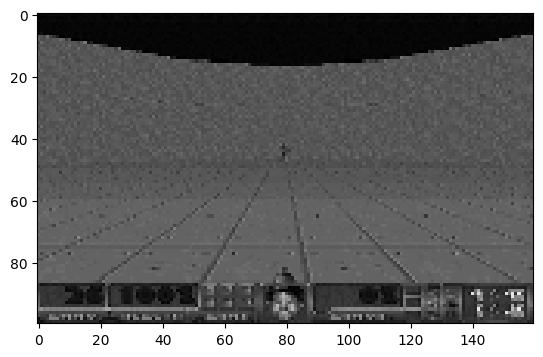

In [23]:
plt.imshow(cv2.cvtColor(state, cv2.COLOR_BGR2RGB))

# 4. Setup Callback

In [ ]:
!pip install torch==1.10.1+cu113 torchvision==0.11.2+cu113 torchaudio===0.10.1+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [ ]:
!pip install stable-baselines3[extra]

In [24]:
# Import os for file nav
import os 
# Import callback class from sb3
from stable_baselines3.common.callbacks import BaseCallback

In [25]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [26]:
CHECKPOINT_DIR = './train/train_center'
LOG_DIR = './logs/log_center'

In [27]:
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

# 5. Train Model

In [28]:
# import ppo for training
from stable_baselines3 import PPO

In [29]:
# Non rendered environment
env = VizDoomGym()

In [30]:

# %pip install 'shimmy>=0.2.1'
model = PPO('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, learning_rate=0.0001, n_steps=2048)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


c:\Users\Pratyush Ranjan\AppData\Local\Programs\Python\Python312\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [31]:
print(model.device)

cuda


In [ ]:
model.learn(total_timesteps=100000, callback=callback)

# 6. Test the Model

In [32]:
# Import eval policy to test agent
from stable_baselines3.common.evaluation import evaluate_policy

In [33]:
# Reload model from disc
model = PPO.load('./train/train_center/DefendCenter100k.zip')

c:\Users\Pratyush Ranjan\AppData\Local\Programs\Python\Python312\Lib\site-packages\stable_baselines3\common\save_util.py:167: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
Exception: code expected at least 16 arguments, got 15
  warnings.warn(
c:\Users\Pratyush Ranjan\AppData\Local\Programs\Python\Python312\Lib\site-packages\stable_baselines3\common\save_util.py:167: UserWarning: Could not deserialize object clip_range. Consider using `custom_objects` argument to replace this object.
Exception: code expected at least 16 arguments, got 15
  warnings.warn(
c:\Users\Pratyush Ranjan\AppData\Local\Programs\Python\Python312\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:95: UserWarning: You loaded a model that was trained using OpenAI Gym. We strongly recommend transitioning to Gymnasium by saving that model again.
  warnings.warn(
c:\Users\Pratyush Ranjan\AppData\Local\Programs\Python\Python312\Lib\si

In [34]:
# Create rendered environment
env = VizDoomGym(render=True)

In [35]:
# Evaluate mean reward for 10 games
mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=100)

c:\Users\Pratyush Ranjan\AppData\Local\Programs\Python\Python312\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
c:\Users\Pratyush Ranjan\AppData\Local\Programs\Python\Python312\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


In [36]:
env.close()

In [37]:
mean_reward

15.76

In [ ]:
# model.predict(obs)

In [38]:
for episode in range(5): 
    obs = env.reset()
    done = False
    total_reward = 0
    while not done: 
        action, _ = model.predict(obs)
        obs, reward, done, info = env.step(action)
        time.sleep(0.20)
        total_reward += reward
    print('Total Reward for episode {} is {}'.format(total_reward, episode))
    time.sleep(2)

ViZDoomIsNotRunningException: Controlled ViZDoom instance is not running or not ready.

In [39]:
env.close()